# Проект.
Максимальная оценка за выполнение всех заданий - **8 баллов**.
Еще **от 0 до 2-х бонусных баллов** дается за совокупность креативных идей, изящность решения (читаемый код, написанный в небольшом объеме, например, использование функционала библиотек вместо простых циклов) и грамотного текстовго описания (этим считается все кроме кода).

Шаблоны кодов даны вам в качестве подсказок и верного направления. Так как это проект, вы можете не использовать эти шаблоны и двигаться в своем направлении.

**Итоговая максимальная оценка: 10 баллов**

## Регрессия

С 1 октября 2022 года отменяется НДС на бриллианты, что делает их новым инвестиционным инструментом. Давайте создадим для них модель ценообразования.

Загрузите набор данных Diamonds.csv.

Он одержит характеристики бриллиантов и их цены.

**Описание признаков**

* fluor - флуоресценция (свойство камня светиться под ультрафиолетом)
* symmetry - индикатор симметрии
* platform - название платформы, на которой был установлен драгоценный камень
* shape - фигура
* color - цвет
* clarity - прозрачность
* cut - качество огранки (может быть только для круглых камней)
* polish - полировка
* id - номер драгоценного камня
* date - дата
* price - цена
* carat - количество каратов
* price_per_carat - цена за карат
* z - длина (диаметр)
* x - ширина
* depth_perc - соотношение высоты и ширины
* y - высота

In [7]:
import pandas as pd
import numpy as np

In [8]:
df = pd.read_csv('diamonds.csv')

df.head()
df.isnull().sum()
df.shape
df.drop(['Unnamed: 0', 'platform'], axis = 1, inplace = True) # удаляем два столбца, так как значения в них не влияют ни на что
df = df[df.id != 0 ] # удаляем строки с id = 0
df['id'].duplicated() # проверяем наличие дублей по id
df.nunique()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222218 entries, 0 to 222221
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fluor            222207 non-null  object 
 1   symmetry         222218 non-null  object 
 2   shape            222218 non-null  object 
 3   color            222218 non-null  object 
 4   clarity          222218 non-null  object 
 5   cut              148981 non-null  object 
 6   polish           222218 non-null  object 
 7   id               222218 non-null  int64  
 8   date             222218 non-null  int64  
 9   price            222218 non-null  float64
 10  carat            222218 non-null  float64
 11  price_per_carat  222218 non-null  float64
 12  z                222218 non-null  float64
 13  x                222218 non-null  float64
 14  depth_perc       222218 non-null  float64
 15  y                222218 non-null  float64
dtypes: float64(7), int64(2), object(7)
mem

,fluor,symmetry,shape,color,clarity,cut,polish,id,date,price,carat,price_per_carat,z,x,depth_perc,y
59329,NONE,VG,EM,D,VS1,NaN,EX,15410668,202207,14750.0,1.5,9833.33,7.84,5.43,65.8,3.57294
98800,NONE,VG,EM,D,VS1,NaN,EX,15410668,202207,14750.0,1.5,9833.33,7.84,5.43,65.8,3.57294


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Необходимо спрогнозировать `price_per_carat`

### Задание 1: Очистка (2 балла)

Не все камни успевают продаться за один месяц, поэтому в таблице есть повторы. Объедините данные по одному камню: подумайте, как лучше это сделать, какую цену брать.

**Попробуйте найти аномалии:** вдруг цена на некоторые камни сильно меняется (то есть продавец сам не знает, по какой цене их продавать). Также убедитесь, что остальные параметры камня не меняются.

In [9]:
from datetime import date
id_stat = df.groupby(by='id')['carat'].count().to_frame() # Видим задвоенные id и их кол-во

id_stat.rename(columns= {'carat': 'repeats'}, inplace = True) # переименовываем колонку для удобного объединения

if not 'repeats' in df:
 df = df.merge(id_stat, how="inner" , left_on="id", right_on = id_stat.index)
df_one = df.query('repeats == 1') # те драгоценные камни, которые встсретились 1 раз
df_three = df.query('repeats == 2 | repeats == 3') # те драгоценные камни, которые встсретились 2-3 раза

stat = df_three.groupby('id')['y'].agg(np.std) # Посчитайте дстандартное отклонение, перебирая столбцы видим, что встречаются аномалии у 'y'

#Ниже пытались удалить ошибочный 'y', но не вышло и цикл очень тормозил
#k = 0
#for index, row in df_three.iterrows():           \\ берем таблицу с 2-3 повторениями
# k = row['id']                                   \\ для каждой строки получаем id
# a = df_three.query('id == @k')                  \\ создаем временную таблицу, с которой будут все повторяющиеся 'y', соответствующие id
# l = a['x'].count()                              \\ если кол-во повторений = 3, то цикл, при 2 - отсортируем датой
# if l == 3:
#  if a.iloc[0] ['y'] == a.iloc[1]['y']:          \\ если y1 = y2, тогда из df_three нужно удалить эту строку
#    t = a.iloc[2]['y']
#    index1 = df_three[df_three['y'] == t ].index  \\ ecли y2 = y3, удаляем строку с y1
#    df_three.drop (index, inplace = True)          \\ecли y1 = y3, удаляем строку с y2, идея была такая, но не заработала

df_three = df.query('repeats == 2')  # поэтому просто удаляем дубли, где 3 одинаковых позиции

df_three = df_three.groupby('id')['date'].agg('last').reset_index() # тепреь в качестве цены возьмем последнее значение по времени

df = pd.concat([df_one, df_three]).reset_index(drop=True) # соединяем результаты



Цены на бриллианты достаточно сильно меняются, попробуйте вычислить коэффициент инфляции и привести цены к последнему месяцу. Стоит учесть, что цены на все бриллианты не изменяются синхронно, то есть изменение в определенных группах может быть разным.

*Определите эти группы и рассчитайте коэффициенты инфляции для каждой из них. Подправьте цены на эти коэффициенты и создайте новую переменную.*

In [10]:
categories = ['carat'] #  #определите по каким группам отпределять инфляцию (к примеру можно добавить каратную группу)

df_index = df.groupby(['date'] + categories)[['price_per_carat']].mean().reset_index() # индекс цен


date_max = df_index.date.max()

df_index = df_index.merge(df_index.query('date == @date_max')[categories + ['price_per_carat']]
                          .rename(columns={'price_per_carat': 'price_per_carat_max'}),
                         on=categories, how='outer') # сопоставляем группы с максимальной датой

df_index['price_per_carat_max'] = df_index['price_per_carat_max']. fillna(df_index['price_per_carat'])
# при объединении таблиц некоторые значения price_per_carat_max остались пустыми, заполняем их price_per_carat

df_index['inflation'] = df_index['price_per_carat_max'] / df_index.price_per_carat # расчет инфляции

df_with_inf = df.merge(df_index[['date'] + categories + ['inflation']], on=['date'] + categories, how='left') # объединить все в одну таблицу

df_with_inf.isnull().sum()
df.drop(['cut'], axis = 1, inplace = True) # удаляем столбцы из-за пропусков
df.drop(['fluor'], axis = 1, inplace = True)

In [11]:
df.isna().sum().sum()
df.dropna(inplace = True) # удаляем пропуски Nan
df.drop(['symmetry', 'shape','color', 'clarity', 'polish'], axis = 1, inplace = True) # не смогли преобразовать столбцы к типу float,
                                                                                      #чтобы не останавливаться на этом и построить модель, решили их удалить
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111617 entries, 0 to 111616
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               111617 non-null  int64  
 1   date             111617 non-null  int64  
 2   price            111617 non-null  float64
 3   carat            111617 non-null  float64
 4   price_per_carat  111617 non-null  float64
 5   z                111617 non-null  float64
 6   x                111617 non-null  float64
 7   depth_perc       111617 non-null  float64
 8   y                111617 non-null  float64
 9   repeats          111617 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 9.4 MB


### Task 2: Модели (6 баллов)

Определите функцию потерь (MSE или MAE) и обоснуйте свой выбор. Постарайтесь установить базовый уровень (baseline). Используйте LabelEncoder для категориальных функций и **создайте линейную модель.**

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # тут в исходнике опечатка, исправьте
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error # тут возможно что-то лишнее
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt

X = df.drop(columns=["price_per_carat"])
y = df["price_per_carat"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)
X_train


,id,date,price,carat,z,x,depth_perc,y,repeats
99597,14567123,202205,7830.0,1.00,6.16,6.24,64.0,3.99360,1.0
96079,14975151,202206,15000.0,1.50,7.42,7.45,59.8,4.45510,1.0
3079,14695840,202205,13990.0,1.50,7.29,7.33,62.0,4.54460,1.0
104829,14202506,202206,29630.0,2.03,8.04,8.10,62.2,5.03820,1.0
15652,14254575,202205,5000.0,1.00,6.80,4.81,68.0,3.27080,1.0
...,...,...,...,...,...,...,...,...,...
87796,15043320,202206,50810.0,5.21,11.07,11.11,61.1,6.78821,1.0
33634,12235304,202207,5270.0,1.01,6.54,4.52,72.4,3.27248,1.0
98378,14904088,202207,5800.0,1.01,5.43,5.25,73.4,3.85350,1.0
47280,15335455,202207,3950.0,1.00,6.18,6.24,63.4,3.95616,1.0


In [ ]:
# из-за того что мы удалили все столбцы, метод OHE применять не пришлось, но мы его пробовали
# он преобразовывал столбцы 'symmetry', 'shape','color', 'clarity', 'polish', создавал столбцы с
# закодированными значениями, но модель KKN все равно ругалась

Теперь попробуйте OHE (One Hot Encoding) или TargetEncoder (сравните их).

Нормализуйте данные.

Поработайте с пропущенными значениями (обратите внимание, что для «fluor» значение может отсутствовать или значение может быть пустым).

Покажите, насколько вам удалось улучшить результат.

In [13]:
! pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.6 MB/s eta 0:00:00


In [14]:
from sklearn.model_selection import train_test_split

# Разобьем датасет на признаки и таргет
X = df.drop(columns=["price_per_carat"])
y = df["price_per_carat"]

# Разделим данные на обучение и тест, воспользовавшись функцией train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 111617 entries, 0 to 111616
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               111617 non-null  int64  
 1   date             111617 non-null  int64  
 2   price            111617 non-null  float64
 3   carat            111617 non-null  float64
 4   price_per_carat  111617 non-null  float64
 5   z                111617 non-null  float64
 6   x                111617 non-null  float64
 7   depth_perc       111617 non-null  float64
 8   y                111617 non-null  float64
 9   repeats          111617 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 9.4 MB


1

ftgh

In [15]:
from sklearn.neighbors import KNeighborsRegressor

df.isna().any()

# Создадим экземпляр класса KNeighborsRegressor с числом ближайших соседей (n_neighbors) равным 3
model_knn = KNeighborsRegressor(n_neighbors = 3)

# Обучим модель
model_knn.fit(X_train, y_train)
# Сделаем предсказание на тестовой выборке
y_pred = model_knn.predict(X_test)
y_pred


array([26246.66666667, 37350.        ,  9056.66666667, ...,
        3663.33333333,  5363.33333333, 22383.33333333])

**1.5 баллов за правильные кодировки, сравнения и KNN**

## Деревья решений (2 балла)

In [16]:
from sklearn.tree import DecisionTreeRegressor


Попробуйте выполнить ту же задачу, но используя модель дерева решений.

In [18]:
# Создадим объект класса DecisionTreeRegressor
DTR = DecisionTreeRegressor()

# Обучим его на обучающей части датасета при помощи метода fit
DTR.fit(X_train, y_train)

# Получим предсказание нашего дерева при помощи метода predict на обучающем и тестовом датасете
y_DTR_train_predict = DTR.predict(X_train)
y_DTR_test_predict = DTR.predict(X_test)

# Посмотрим на наши метрики на обучении и тесте и проанализирем работу алгоритма
print("TRAIN")
print(f"MAX ERROR: {max_error(y_train, y_DTR_train_predict)}")
print(f"MAE:       {mean_absolute_error(y_train, y_DTR_train_predict)}")
print("TEST")
print(f"MAX ERROR: {max_error(y_test, y_DTR_test_predict)}")
print(f"MAE:       {mean_absolute_error(y_test, y_DTR_test_predict)}")

TRAIN
MAX ERROR: 0.0
MAE:       0.0
TEST
MAX ERROR: 391810.0
MAE:       172.8252105357463


In [20]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(
            DecisionTreeRegressor(),                # Алгоритм, в котором будем подбирать параметры
            param_grid = {                          # Сетка параметров в виде словаря
                'max_depth': range(1, 8),
                'min_samples_leaf': range(1, 8),
            },
            scoring = 'neg_mean_absolute_error',    # Какие метрики будут считаться (Почему "neg_..."?)
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid.fit(X_train, y_train)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(1, 8),
                         'min_samples_leaf': range(1, 8)},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=5)

In [22]:
y_GS_train_predict = grid.best_estimator_.predict(X_train)
y_GS_test_predict = grid.best_estimator_.predict(X_test)

# Посмотрим на наши метрики на обучении и тесте и проанализирем работу алгоритма
print("TRAIN")
print(f"MAX ERROR: {max_error(y_train, y_GS_train_predict)}")
print(f"MAE:       {mean_absolute_error(y_train, y_GS_train_predict)}")
print("TEST")
print(f"MAX ERROR: {max_error(y_test, y_GS_test_predict)}")
print(f"MAE:       {mean_absolute_error(y_test, y_GS_test_predict)}")

TRAIN
MAX ERROR: 957500.0
MAE:       801.8675777224221
TEST
MAX ERROR: 407427.14285714284
MAE:       821.3505202023975


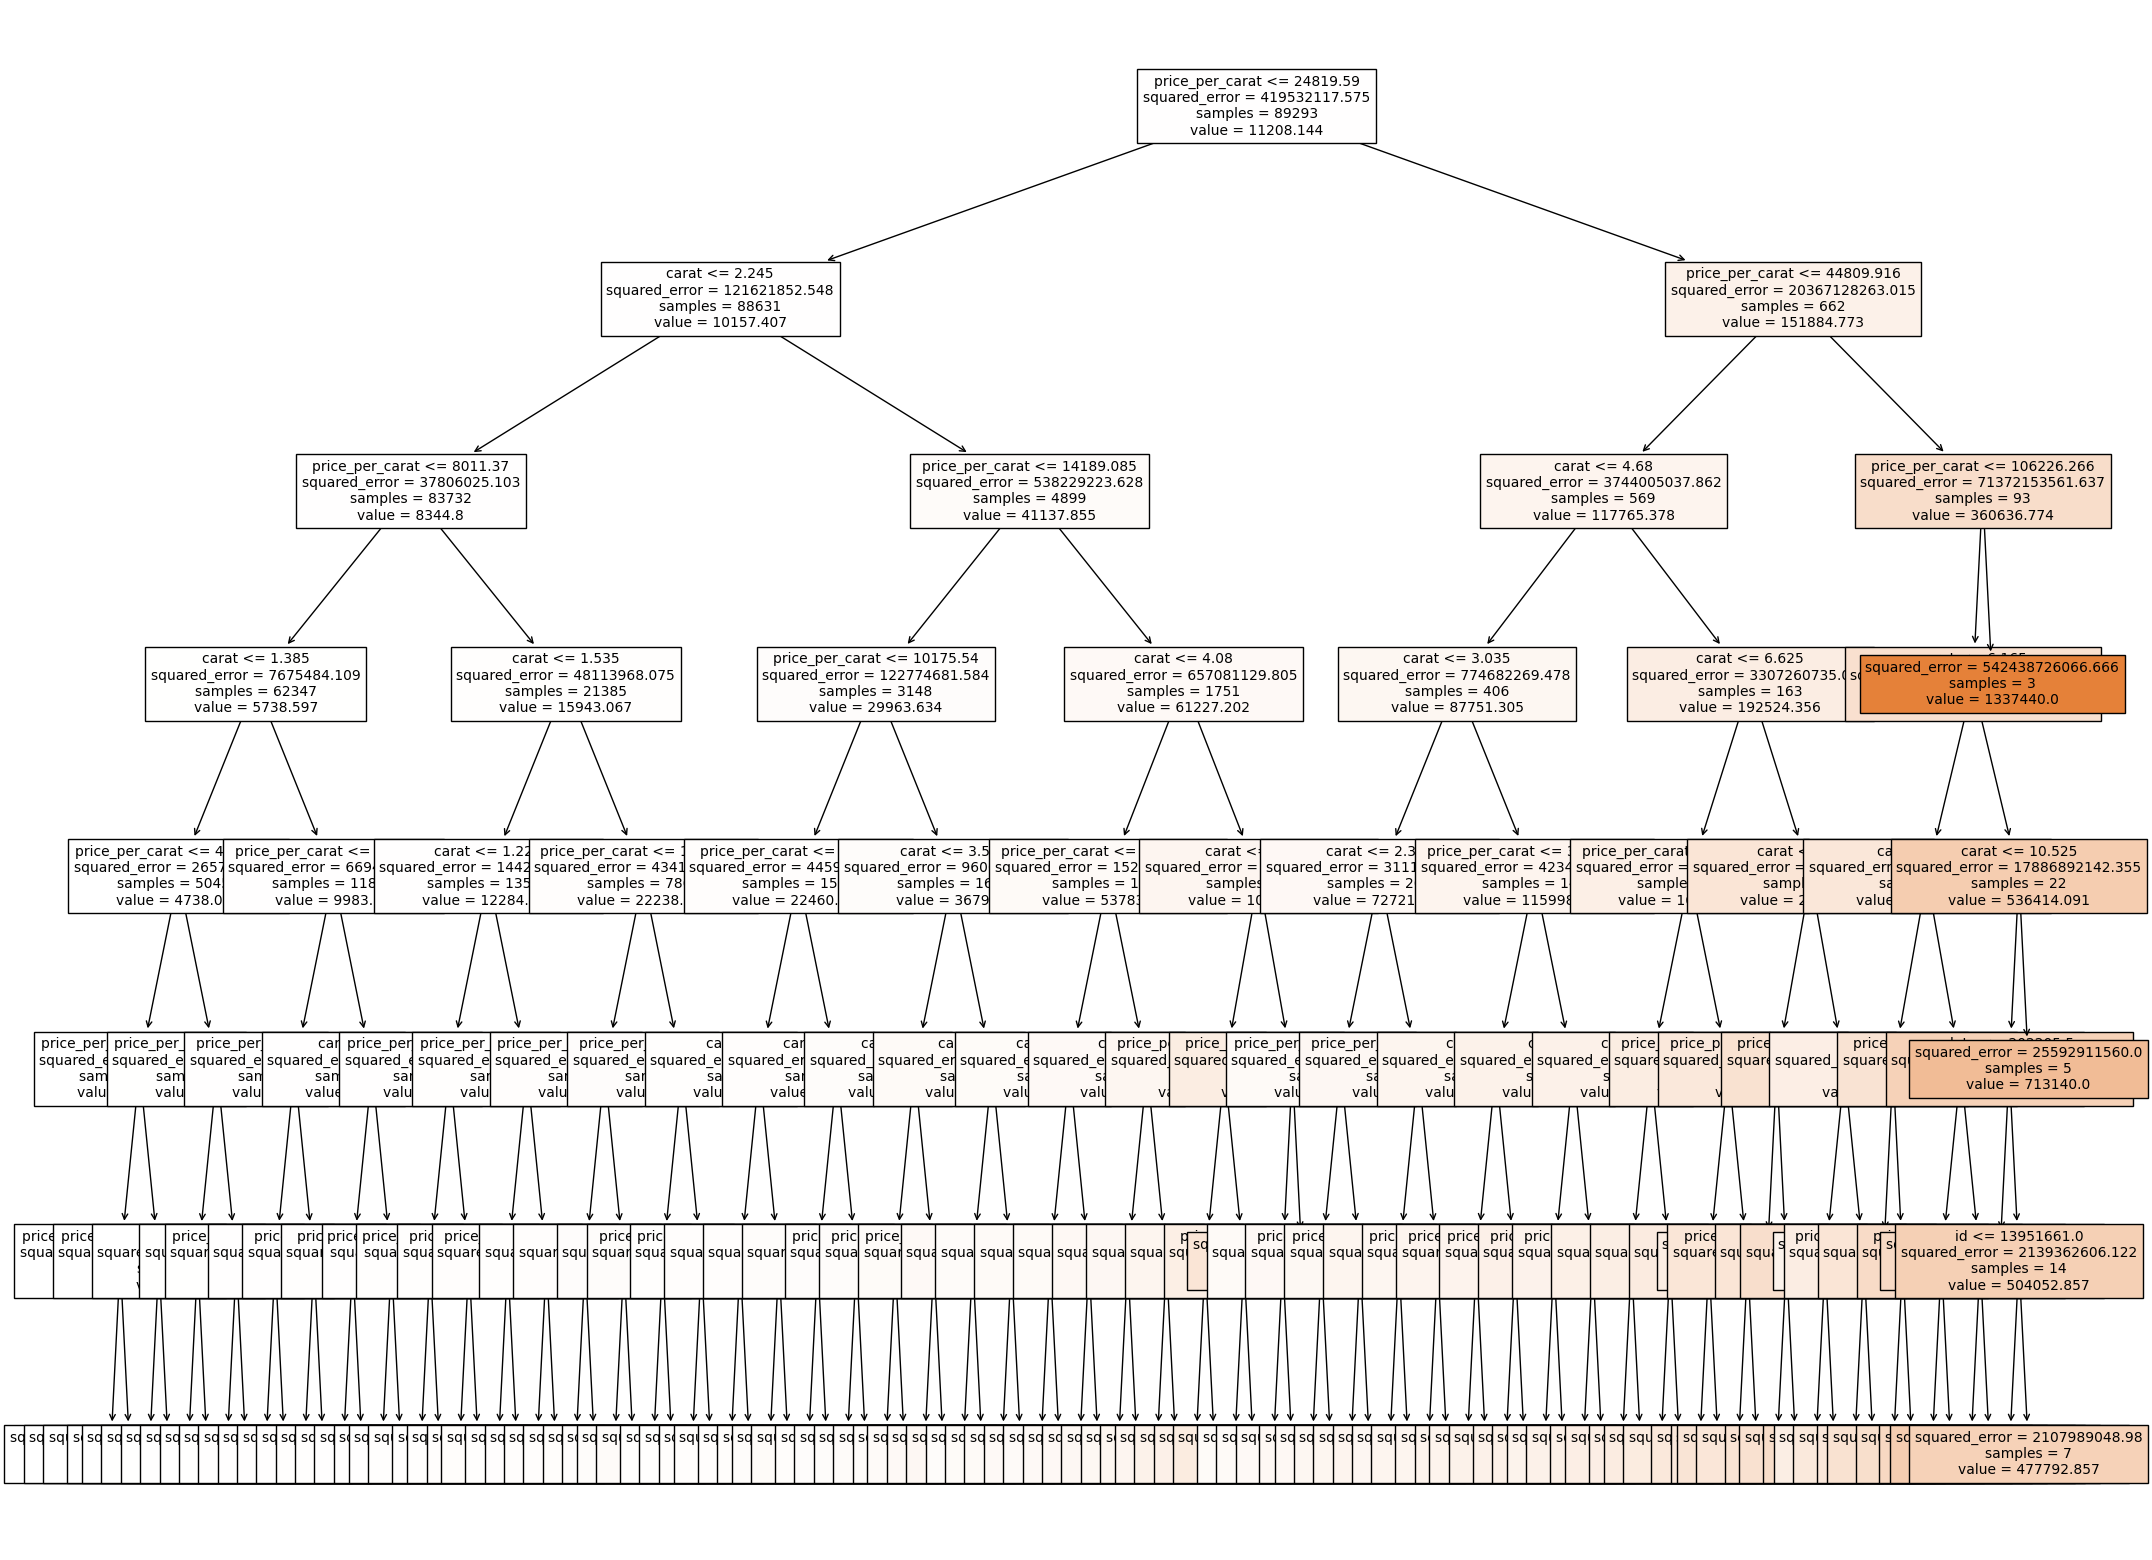

In [23]:
# Нарисуем наше лучшее дерево из сетки
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(25,20))

_ = plot_tree(
        grid.best_estimator_,
        feature_names = X_train.columns,
        class_names = y_train.name,
        filled = True,
        fontsize = 10
    )

## Ансамблевые методы (2 балла)

Попробуйте выполнить ту же задачу, но используя ансамблевые методы (модель случайного леса).

In [24]:
# your code here
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)# подгонка модели к данным
rf_pre =rf.predict(X_test) # прогноз цены на X_test
print('Точность Random Forest Regressor : ')
mser = mean_squared_error(y_test, rf_pre)
rmser = mean_squared_error(y_test, rf_pre)**0.5
maer = mean_absolute_error(y_test, rf_pre)
#r2r = r2r_score(y_test, rf_pre)

#print('R2            : ', r2r)
print('MAE           : ', maer)
print('MSE (RMSE)    : ', mser)

Точность Random Forest Regressor : 


NameError: ignored

## Заключение (0.5 баллов)

Сравните все модели, выберите лучшую и сделайте вывод о проекте в целом.

< Ваш вывод здесь >